# Canny Edge in Programmable Logic (PL) - Application Notebook

##### This reference design illustrates how to run a Canny Edge IP on the **Programmable Logic (PL)** using Jupyter Notebooks and Python

## Image Canny detection in Programmable Logic


<img src="./images/resize_bd.png" width="800" height="650"/>

## Import libraries

In [18]:
from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay

## Download the Image Processing IP bitstream

In [19]:
CannyEdge_design = Overlay("./bitstream/CannyEdge.bit")

Then create DMA and Canny Edge IP objects.

In [20]:
dma = CannyEdge_design.axi_dma_0

In [21]:
CannyEdge = CannyEdge_design.canny_edge_0


<img src="./images/resize_bit.png" width="600" height="450"/>


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

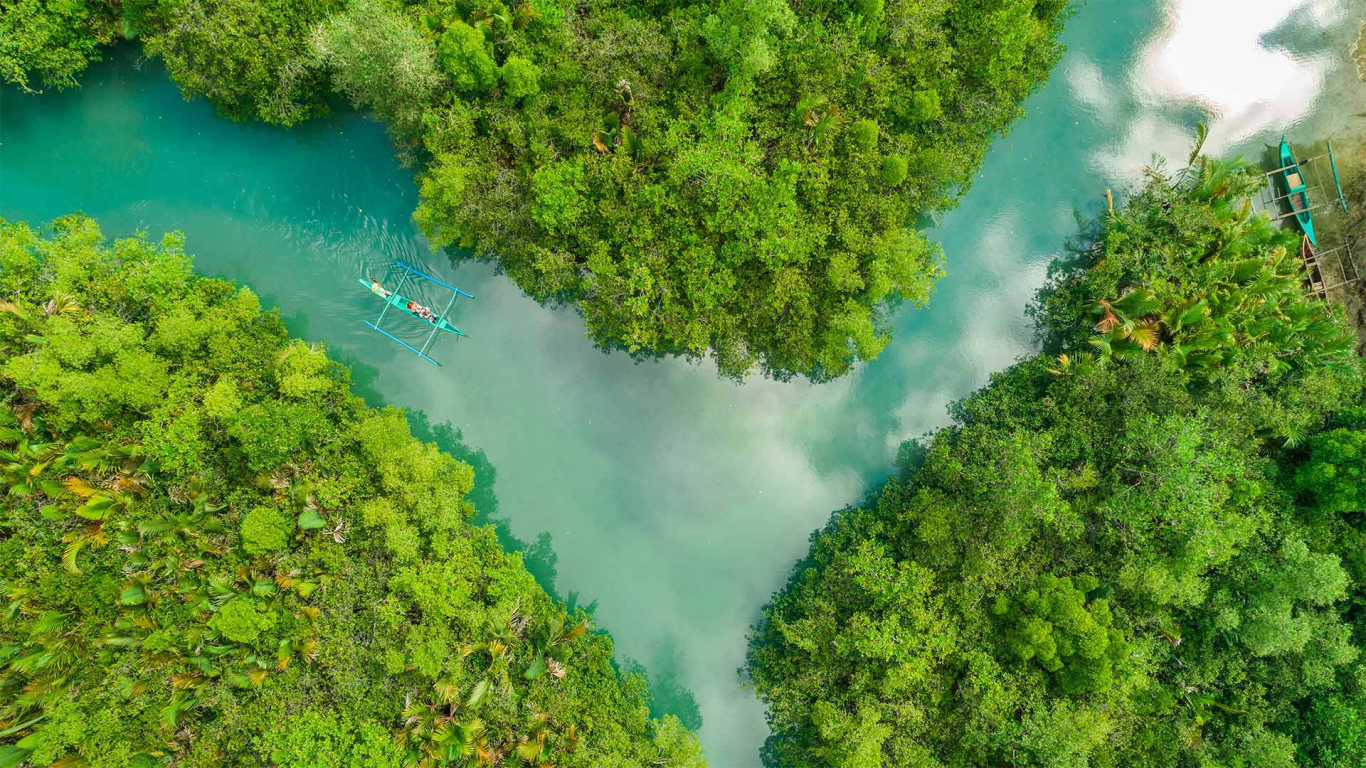

In [22]:
image_path = "images/bing.bmp"
original_image = Image.open(image_path)
display(original_image)

In [23]:
pic_width, pic_height = original_image.size
print("Image size: {}x{} pixels.".format(pic_width, pic_height))

Image size: 1366x768 pixels.


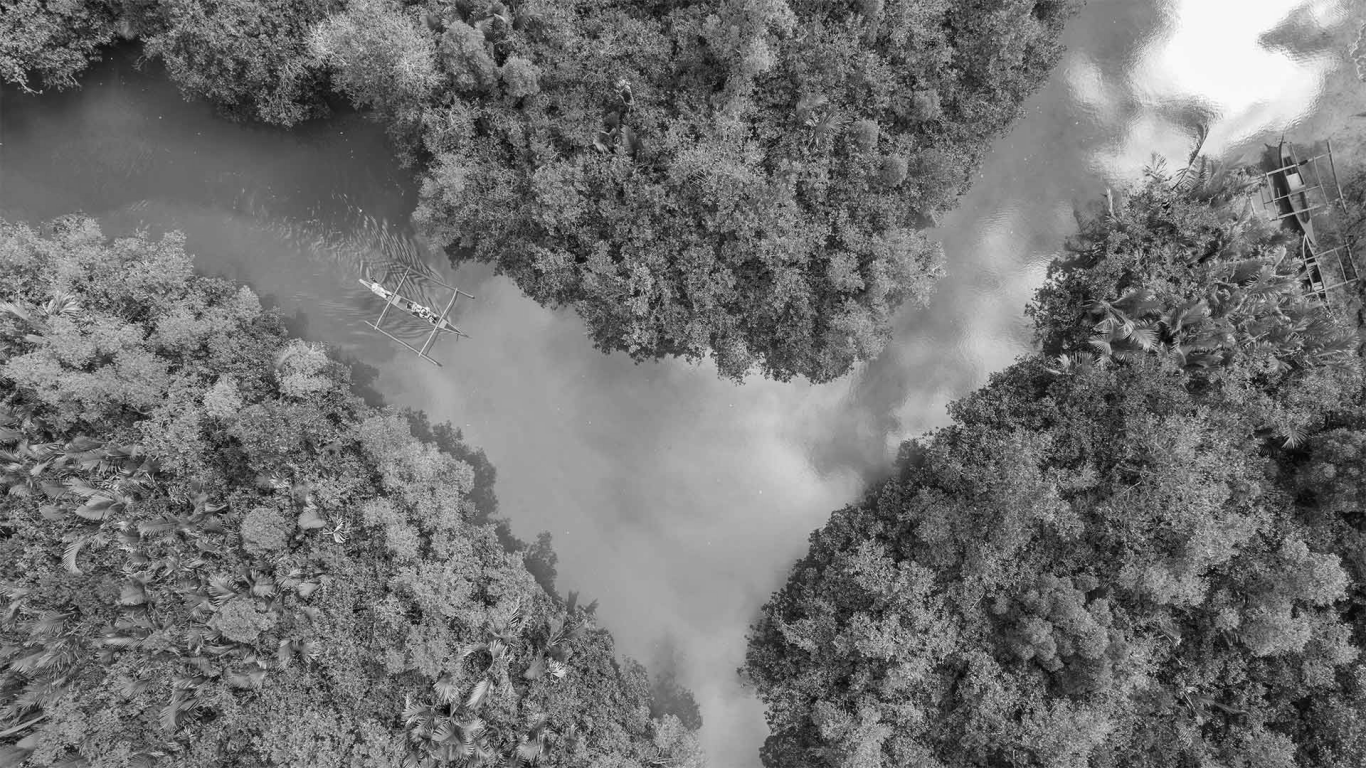

In [24]:
original_image = original_image.convert('L') #gray scale the loaded image
display(original_image)

We now create a numpy array of the pixels.

In [47]:
input_array = np.array(original_image)

<img src="images/sd2dram.png" width="650" height="550"/>

We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `cma_array()` to perform the allocation.

In [48]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(pic_height, pic_width), 
                           dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(1), 
                            dtype=np.uint32)

Documentation snippet for `xlnk.cma_array`:

```python
"""
Get a contiguously allocated numpy array

Parameters
----------
shape : int or tuple of int
    The dimensions of the array to construct - We use (height, width, depth)
dtype : numpy.dtype or str
    The data type to construct - We use 8-bit unsigned int

"""
```


<img src="./images/local2shared.png" width="650" height="550"/>


We now display the image in buffer.

__Note : The `input_array` has to be copied into the contiguous memory array (deep copy).__

The input buffer size should be 640 x 360 x 3 (height x width x depth).

In [49]:
np.copyto(in_buffer,input_array)
#in_buffer.nbytes = input_array.nbytes
buf_image = Image.fromarray(in_buffer)
#display(buf_image)
#print("Image size: {}x{} pixels.".format(pic_width, pic_height))

We can now run the canny edge IP.
We will push the data from input buffer through the pipeline to the output buffer.


<img src="./images/resize_accel.png" width="650" height="550"/>


We will first need to setup resizer and DMA IPs using MMIO interface 
before we stream image data to them.
For example, we need to write dimensions data to MMIO registers of resizer.

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x14            | number of rows for original picture    |
| 0x1C            | number of columns for original picture |
| 0x24            | Data signal of threshold1     |
| 0x2C            | Data signal of threshold2  |

In [51]:
CannyEdge.write(0x14, pic_height) #rows
CannyEdge.write(0x1c, pic_width) #cols

In [52]:
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)    
CannyEdge.write(0x00,0x81) # start

In [53]:
dma.sendchannel.wait()

In [54]:
dma.recvchannel.wait()

In [55]:
out_buffer

PynqBuffer([5], dtype=uint32)

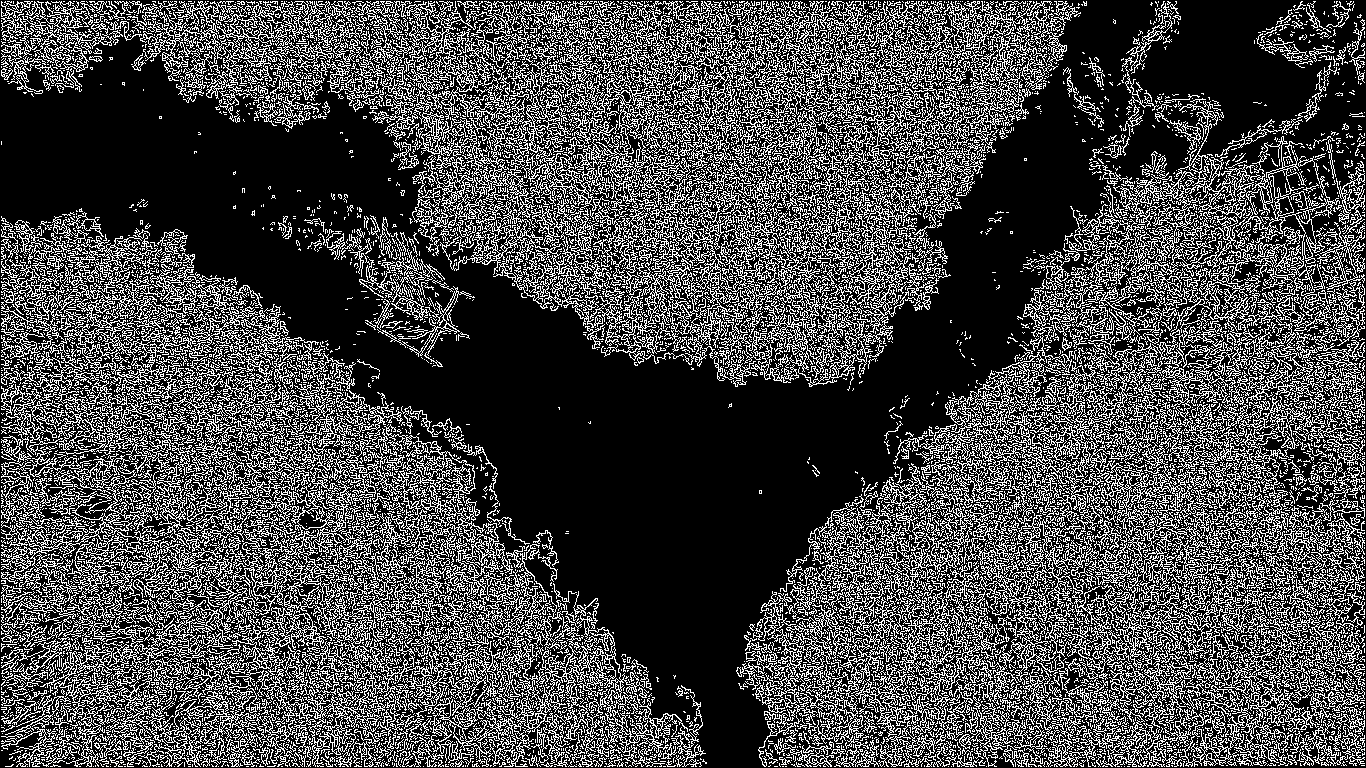

Canny edged in Hardware(PL): 1366x768 pixels.


In [15]:
result = Image.fromarray(out_buffer)
display(result)
print("Canny edged in Hardware(PL): {}x{} pixels.".format(pic_width, pic_height))

In [17]:
out_buffer.shape

(768, 1366)

Finally we need to reset all the contiguous memory buffers.

In [54]:
in_buffer.close()
out_buffer.close()

In [55]:
xlnk.xlnk_reset()

[Contents](#Contents)

# References

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   